In [1]:
import os
import warnings

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("‚úì TOKENIZERS_PARALLELISM configurado a 'false' para evitar warnings")

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")

print("‚úì Configuraci√≥n de warnings completada")

‚úì TOKENIZERS_PARALLELISM configurado a 'false' para evitar warnings
‚úì Configuraci√≥n de warnings completada


# Modelado de T√≥picos con BERTopic

Este notebook implementa un an√°lisis de t√≥picos usando BERTopic sobre las opiniones tur√≠sticas clasificadas. Utiliza LangChain con GPT-4o-mini para asignar nombres sem√°nticamente coherentes a los t√≥picos identificados.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
import os
import sys
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from typing import Literal
import nltk

sys.path.append('../scripts')

from topicos import LimpiadorTextoMejorado, generar_reporte_limpieza, mostrar_ejemplos_limpieza

load_dotenv()

nltk.download('punkt_tab')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

‚úì Modelo spaCy espa√±ol cargado
‚úì Modelo spaCy ingl√©s cargado
‚úì Modelo spaCy portugu√©s cargado
‚úì Modelo spaCy franc√©s cargado
‚úì Modelo spaCy italiano cargado
Descargando wordnet...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/victorwkey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/victorwkey/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
from topicos import configurar_clasificador_topicos, configurar_bertopic_inteligente

clasificador_topicos = configurar_clasificador_topicos()

In [4]:
CIUDAD_ANALIZAR = "Puerto_vallarta"
df = pd.read_csv('../data/processed/dataset_opiniones_analisis.csv')

if 'TopicoConBERTopic' not in df.columns:
    df['TopicoConBERTopic'] = np.nan

print(f"Dataset cargado: {df.shape[0]} opiniones")
print(f"Columnas disponibles: {list(df.columns)}")
print(f"\nDistribuci√≥n total por ciudad:")
print(df['Ciudad'].value_counts())

df_ciudad = df[df['Ciudad'] == CIUDAD_ANALIZAR].copy()

columna_texto = 'TituloReviewLimpio'

texts = df_ciudad[columna_texto].dropna().tolist()

palabras_promedio = sum(len(text.split()) for text in texts) / len(texts)
print(f"üìä Promedio de palabras por texto: {palabras_promedio:.1f}")
print(f"üìè Longitud promedio: {sum(len(text) for text in texts) / len(texts):.1f} caracteres")

Dataset cargado: 2464 opiniones
Columnas disponibles: ['Titulo', 'Review', 'Calificacion', 'FechaEstadia', 'Ciudad', 'Atraccion', 'TituloReview', 'TituloReviewLimpio', 'SentimientoPorCalificacion', 'SentimientoPorHF', 'SentimientoPorCardiff', 'SubjetividadConHF', 'SubjetividadConFrases', 'SubjetividadConLLM', 'TopicoConBERTopic']

Distribuci√≥n total por ciudad:
Ciudad
Puebla             500
Mazatlan           500
Puerto_vallarta    491
Cdmx               490
Cancun             483
Name: count, dtype: int64
üìä Promedio de palabras por texto: 31.8
üìè Longitud promedio: 229.3 caracteres


In [5]:
columna_limpia = "TituloReviewLimpio"

if columna_limpia not in df.columns:

    limpiador = LimpiadorTextoMejorado(idiomas=['spanish', 'english'])

    df_antes = df.copy()

    df = limpiador.limpiar_dataframe(
        df,
        columna_texto='TituloReview',
        nombre_columna_limpia=columna_limpia,
        aplicar_lematizacion=True,
        min_longitud_palabra=2,
        max_palabras=None
    )

    mostrar_ejemplos_limpieza(df, n_ejemplos=3)

    generar_reporte_limpieza(df_antes, df, 'TituloReview', columna_limpia)

    df.to_csv('../data/processed/dataset_opiniones_analisis.csv', index=False)

In [6]:
# ===== CONFIGURACI√ìN INTELIGENTE DE BERTOPIC =====
topic_model, reporte_optimizacion = configurar_bertopic_inteligente(texts)
    
print("ü§ñ Configuraci√≥n autom√°tica de BERTopic completada")
print(reporte_optimizacion)

print("\nüöÄ Entrenando modelo con hiperpar√°metros optimizados...")
topics, probs = topic_model.fit_transform(texts)


ü§ñ Configuraci√≥n autom√°tica de BERTopic completada
ü§ñ OPTIMIZACI√ìN AUTOM√ÅTICA DE BERTOPIC

üìä CARACTER√çSTICAS DEL DATASET:
   N√∫mero de textos: 491
   Palabras promedio: 31.8
   Diversidad l√©xica: 0.258
   Homogeneidad: 0.496
   Densidad sem√°ntica: 0.431

‚öôÔ∏è HIPERPAR√ÅMETROS OPTIMIZADOS:
   Embedding: paraphrase-multilingual-MiniLM-L12-v2
   UMAP n_neighbors: 24
   UMAP n_components: 25
   HDBSCAN min_cluster_size: 26
   Vectorizer max_features: 350
   Vectorizer ngram_range: (1, 3)

üí° JUSTIFICACIONES:
   - Baja diversidad: dimensiones reducidas y filtrado m√°s restrictivo
   - Textos heterog√©neos: clusters m√°s peque√±os para capturar variabilidad

üöÄ Entrenando modelo con hiperpar√°metros optimizados...


In [7]:
topic_info = topic_model.get_topic_info()
print(f"T√≥picos identificados: {len(topic_info)} (incluyendo outliers)")

topic_names = {}
for topic_id in topic_info['Topic']:
    if topic_id == -1:
        topic_names[topic_id] = "Opiniones Diversas"
        continue
    
    topic_words = topic_model.get_topic(topic_id)
    keywords = ", ".join([word for word, _ in topic_words[:8]])
    
    resultado = clasificador_topicos.invoke({"keywords": keywords})
    topic_names[topic_id] = resultado.nombre_topico
    
    print(f"T√≥pico {topic_id}: {topic_names[topic_id]}")
    print(f"  Palabras clave: {keywords}")
    print()

topic_model.set_topic_labels(topic_names)

T√≥picos identificados: 6 (incluyendo outliers)
T√≥pico 0: Experiencia en playas tranquilas
  Palabras clave: playa, mas, beach, agua, tranquilo, vendedor, hermoso playa, limpio

T√≥pico 1: Esfuerzo en la Aventura
  Palabras clave: pena, valer pena, escalera, valer, subir, empinado, caminata, ejercicio

T√≥pico 2: Arquitectura religiosa hermosa
  Palabras clave: iglesia, church, hermoso iglesia, dentro, edificio, beautiful, puerto vallarta, malecon

T√≥pico 3: Servicio de gu√≠as tur√≠sticos
  Palabras clave: super, guia, servicio, atento, equipo, amable, mejor, divertido

T√≥pico 4: Experiencia Gastron√≥mica y Recreativa
  Palabras clave: restaurante, tienda, zona, ambiente, deportivo, calle, pasear, tienda restaurante



In [8]:
# Procesar solo datos de la ciudad seleccionada
df_con_topicos = df_ciudad.dropna(subset=[columna_texto]).copy()
df_con_topicos['Topico'] = topics
df_con_topicos['Topico_Nombre'] = df_con_topicos['Topico'].map(topic_names)
df_con_topicos['Probabilidad_Topico'] = probs.max(axis=1)

# Verificar si la ciudad ya ten√≠a resultados previos
indices_ciudad = df_con_topicos.index
opiniones_previas = df.loc[indices_ciudad, 'TopicoConBERTopic'].notna().sum()

if opiniones_previas > 0:
    print(f"üîÑ SOBRESCRIBIENDO resultados previos para {CIUDAD_ANALIZAR}:")
    print(f"   üìù Opiniones con t√≥picos previos: {opiniones_previas}")
    print(f"   üÜï Nuevas asignaciones de t√≥picos: {len(df_con_topicos)}")
else:
    print(f"üÜï PRIMERA VEZ procesando {CIUDAD_ANALIZAR}:")
    print(f"   üìù Nuevas asignaciones de t√≥picos: {len(df_con_topicos)}")

# Actualizar el dataset original con los t√≥picos de la ciudad analizada
df.loc[indices_ciudad, 'TopicoConBERTopic'] = df_con_topicos['Topico_Nombre']

print(f"\n‚úÖ Actualizaci√≥n completada para {CIUDAD_ANALIZAR}")
print(f"Distribuci√≥n de t√≥picos en {CIUDAD_ANALIZAR}:")
topico_counts = df_con_topicos['Topico_Nombre'].value_counts()
print(topico_counts)

print(f"\nPorcentaje de opiniones por t√≥pico en {CIUDAD_ANALIZAR}:")
topico_pct = (topico_counts / len(df_con_topicos) * 100).round(2)
for topico, pct in topico_pct.items():
    print(f"{topico}: {pct}%")

print(f"\nEstado actualizaci√≥n dataset completo:")
print(f"Total opiniones: {len(df)}")
print(f"Opiniones con t√≥pico asignado: {df['TopicoConBERTopic'].notna().sum()}")
print(f"Opiniones pendientes: {df['TopicoConBERTopic'].isna().sum()}")

# Mostrar calidad de la limpieza aplicada
if columna_texto == 'TituloReviewLimpio':
    textos_vacios = df_con_topicos[columna_texto].str.strip().eq('').sum()
    print(f"\nüßπ Calidad de limpieza en {CIUDAD_ANALIZAR}:")
    print(f"Textos vac√≠os tras limpieza: {textos_vacios}")
    print(f"Textos v√°lidos para an√°lisis: {len(df_con_topicos) - textos_vacios}")
    
    # Comparar longitud promedio original vs limpia
    if 'TituloReview' in df_con_topicos.columns:
        len_original = df_con_topicos['TituloReview'].str.len().mean()
        len_limpia = df_con_topicos['TituloReviewLimpio'].str.len().mean()
        reduccion = ((len_original - len_limpia) / len_original * 100)
        print(f"Reducci√≥n promedio de texto: {reduccion:.1f}%")

üîÑ SOBRESCRIBIENDO resultados previos para Puerto_vallarta:
   üìù Opiniones con t√≥picos previos: 491
   üÜï Nuevas asignaciones de t√≥picos: 491

‚úÖ Actualizaci√≥n completada para Puerto_vallarta
Distribuci√≥n de t√≥picos en Puerto_vallarta:
Topico_Nombre
Opiniones Diversas                       251
Experiencia en playas tranquilas          79
Esfuerzo en la Aventura                   51
Arquitectura religiosa hermosa            43
Servicio de gu√≠as tur√≠sticos              38
Experiencia Gastron√≥mica y Recreativa     29
Name: count, dtype: int64

Porcentaje de opiniones por t√≥pico en Puerto_vallarta:
Opiniones Diversas: 51.12%
Experiencia en playas tranquilas: 16.09%
Esfuerzo en la Aventura: 10.39%
Arquitectura religiosa hermosa: 8.76%
Servicio de gu√≠as tur√≠sticos: 7.74%
Experiencia Gastron√≥mica y Recreativa: 5.91%

Estado actualizaci√≥n dataset completo:
Total opiniones: 2464
Opiniones con t√≥pico asignado: 2464
Opiniones pendientes: 0

üßπ Calidad de limpieza en Puerto

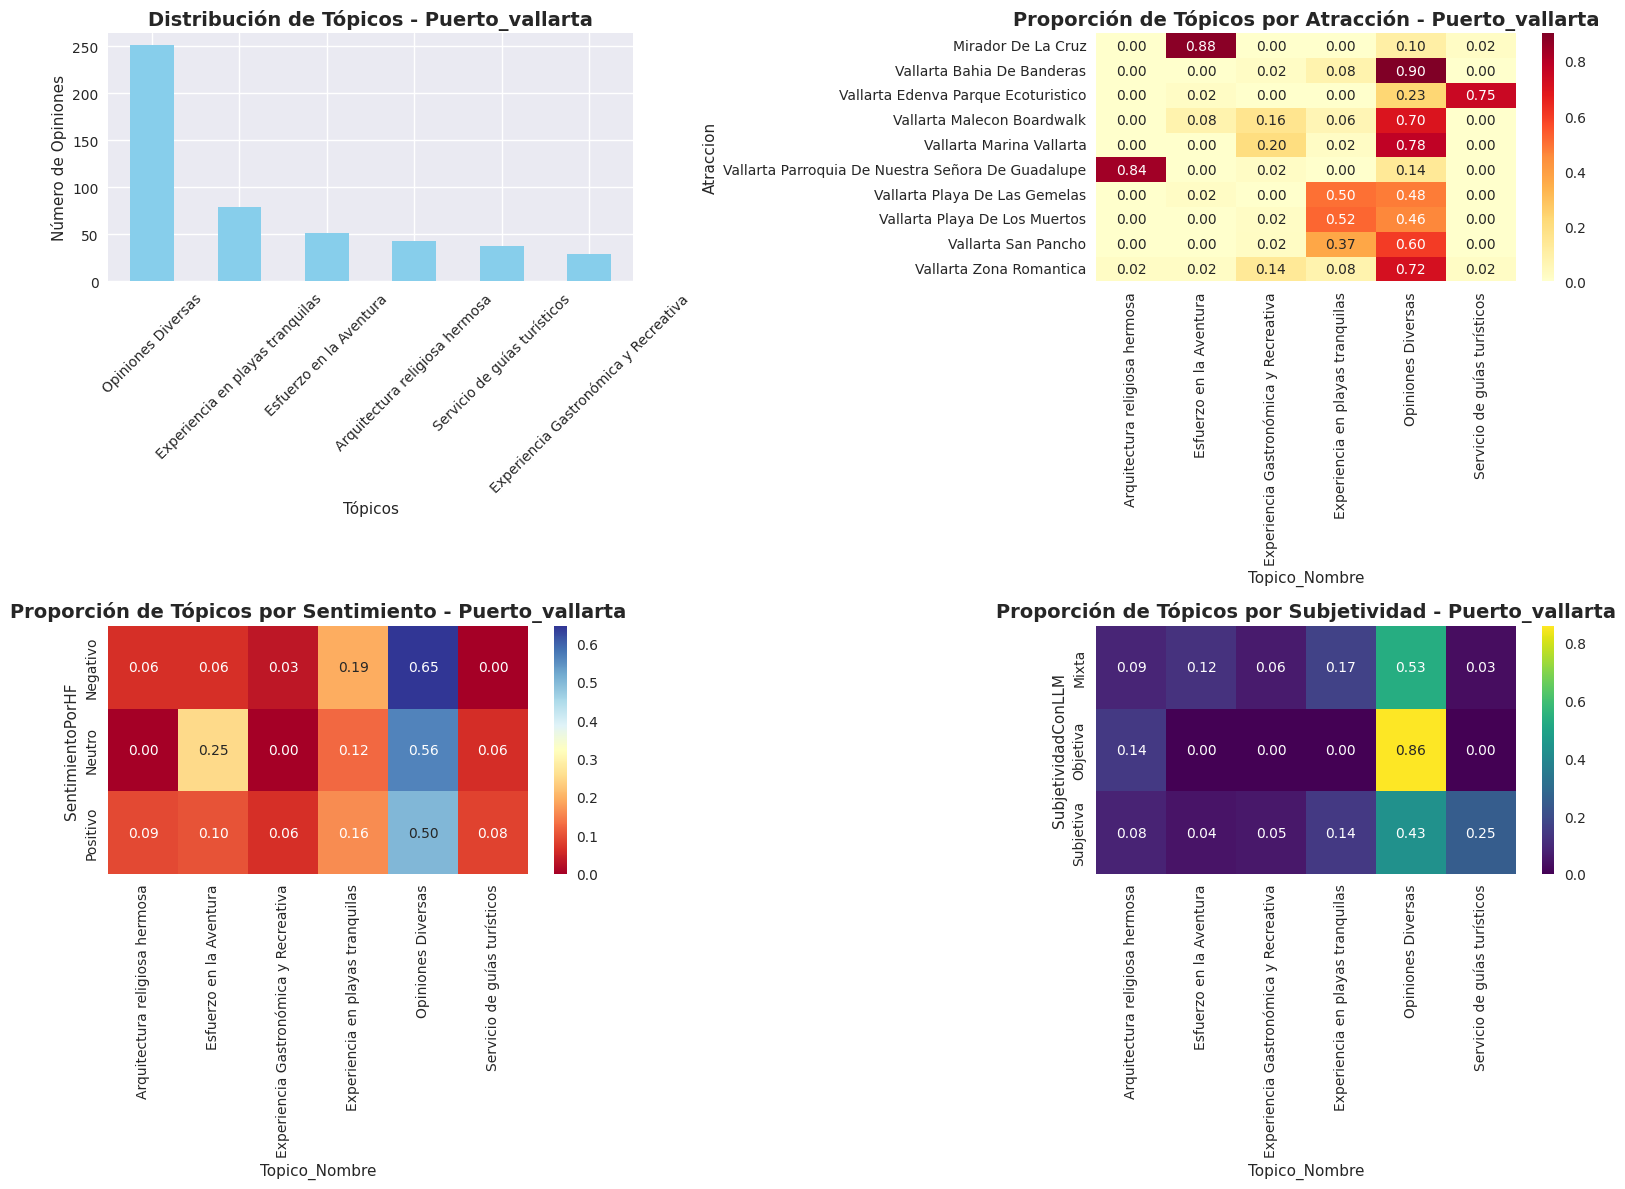

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gr√°fico 1: Distribuci√≥n de t√≥picos en la ciudad
topico_counts.plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title(f'Distribuci√≥n de T√≥picos - {CIUDAD_ANALIZAR}', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('T√≥picos')
axes[0,0].set_ylabel('N√∫mero de Opiniones')
axes[0,0].tick_params(axis='x', rotation=45)

# Gr√°fico 2: Distribuci√≥n por atracci√≥n en la ciudad
if len(df_con_topicos['Atraccion'].unique()) > 1:
    atraccion_topico = pd.crosstab(df_con_topicos['Atraccion'], df_con_topicos['Topico_Nombre'])
    atraccion_topico_norm = atraccion_topico.div(atraccion_topico.sum(axis=1), axis=0)
    sns.heatmap(atraccion_topico_norm, annot=True, fmt='.2f', ax=axes[0,1], cmap='YlOrRd')
    axes[0,1].set_title(f'Proporci√≥n de T√≥picos por Atracci√≥n - {CIUDAD_ANALIZAR}', fontsize=14, fontweight='bold')
else:
    axes[0,1].text(0.5, 0.5, f'Solo una atracci√≥n en {CIUDAD_ANALIZAR}', ha='center', va='center', transform=axes[0,1].transAxes)
    axes[0,1].set_title(f'Distribuci√≥n por Atracci√≥n - {CIUDAD_ANALIZAR}', fontsize=14, fontweight='bold')

# Gr√°fico 3: T√≥picos por sentimiento
sentimiento_topico = pd.crosstab(df_con_topicos['SentimientoPorHF'], df_con_topicos['Topico_Nombre'])
sentimiento_topico_norm = sentimiento_topico.div(sentimiento_topico.sum(axis=1), axis=0)
sns.heatmap(sentimiento_topico_norm, annot=True, fmt='.2f', ax=axes[1,0], cmap='RdYlBu')
axes[1,0].set_title(f'Proporci√≥n de T√≥picos por Sentimiento - {CIUDAD_ANALIZAR}', fontsize=14, fontweight='bold')

# Gr√°fico 4: T√≥picos por subjetividad
subjetividad_topico = pd.crosstab(df_con_topicos['SubjetividadConLLM'], df_con_topicos['Topico_Nombre'])
subjetividad_topico_norm = subjetividad_topico.div(subjetividad_topico.sum(axis=1), axis=0)
sns.heatmap(subjetividad_topico_norm, annot=True, fmt='.2f', ax=axes[1,1], cmap='viridis')
axes[1,1].set_title(f'Proporci√≥n de T√≥picos por Subjetividad - {CIUDAD_ANALIZAR}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [10]:
print(f"Ejemplos de opiniones por t√≥pico en {CIUDAD_ANALIZAR}:")
print("=" * 60)

for topico_nombre in topico_counts.index[:5]:
    ejemplos = df_con_topicos[df_con_topicos['Topico_Nombre'] == topico_nombre]['TituloReview'].head(3)
    print(f"\nüè∑Ô∏è T√≥pico: {topico_nombre}")
    print(f"üìä Total de opiniones: {topico_counts[topico_nombre]}")
    print("üìù Ejemplos:")
    for i, ejemplo in enumerate(ejemplos, 1):
        print(f"  {i}. {ejemplo[:100]}{'...' if len(ejemplo) > 100 else ''}")
    print("-" * 50)

Ejemplos de opiniones por t√≥pico en Puerto_vallarta:

üè∑Ô∏è T√≥pico: Opiniones Diversas
üìä Total de opiniones: 251
üìù Ejemplos:
  1. Para algunos es cansada la subida,pero les aseguro que no se arrepentir√°n cuando lleguen y disfruten...
  2. Gorgeous Sunset view!. Hermosa experiencia y maravillosa vista de la Bahia desde el Mirador de la Cr...
  3. Mejor vista panor√°mica de Puerto Vallarta. Esta es una excelente caminata a trav√©s de las calles emp...
--------------------------------------------------

üè∑Ô∏è T√≥pico: Experiencia en playas tranquilas
üìä Total de opiniones: 79
üìù Ejemplos:
  1. THEY ARE POLLUTING OUR STUARIE AND MANGROVES. CONTAMINAN, THEY POLLUTE OUR STUARY, PLEASE DO SOMETHI...
  2. M√°s que una playa. Mucho m√°s que una hermosa playa. Restaurantes, tiendas, r√≠os y una hermosa vista ...
  3. Playa divertida y limpia. Playa muy agradable y limpia. Tranquilo y sin mucho ruido. Rodeado de rest...
--------------------------------------------------

üè∑Ô∏è 

üîç Comparaci√≥n de ejemplos - Original vs Limpio (Puerto_vallarta):

üìÑ EJEMPLO 1 - T√≥pico: Esfuerzo en la Aventura
üî∏ Original: ¬°Muy factible para disfrutar de unas vistas preciosas!. Un excelente paseo activo por aceras empinadas y escaleras con barandillas para disfrutar de maravillosas vistas. Tom√© la ruta directa por la calle Abisolo, gir√© a la izquierda en el cruce en T y lo disfrut√© a pesar de las obras en la zona. Recomendado como actividad f√≠sica saludable, mejor en las horas m√°s frescas de la ma√±ana.
üîπ Limpio:   factible disfrutar uno vista precioso excelente paseo activo acera empinada escalera barandilla disfrutar maravillosa vistas tome ruta directo calle abisolo gire izquierdo cruce disfrutir pesar obra zona recomendado actividad fisico saludable mejor hora mas fresco man√°n
üìä Caracteres: 386 ‚Üí 270 (30.1% reducci√≥n)
üìù Palabras: 66 ‚Üí 36 (45.5% reducci√≥n)
--------------------------------------------------------------------------------

üìÑ EJEM

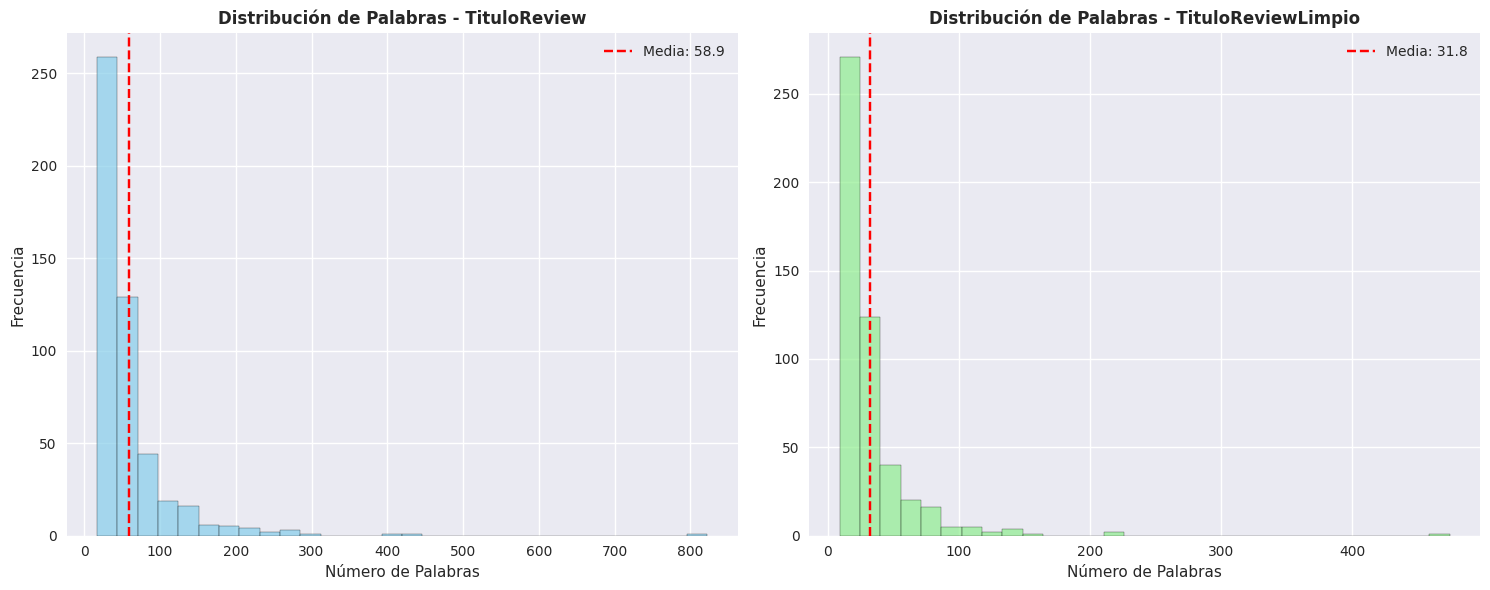

üìä ESTAD√çSTICAS DE DISTRIBUCI√ìN DE PALABRAS:
Original - Media: 58.9, Mediana: 41.0
Limpio   - Media: 31.8, Mediana: 23.0


In [11]:
# ===== COMPARACI√ìN TEXTO ORIGINAL VS TEXTO LIMPIO =====

if 'TituloReviewLimpio' in df_con_topicos.columns:
    print(f"üîç Comparaci√≥n de ejemplos - Original vs Limpio ({CIUDAD_ANALIZAR}):")
    print("=" * 80)
    
    # Seleccionar algunos ejemplos para mostrar la diferencia
    ejemplos_muestra = df_con_topicos.sample(n=min(15, len(df_con_topicos)))
    
    for i, (_, row) in enumerate(ejemplos_muestra.iterrows(), 1):
        print(f"\nüìÑ EJEMPLO {i} - T√≥pico: {row['Topico_Nombre']}")
        print(f"üî∏ Original: {row['TituloReview']}")
        print(f"üîπ Limpio:   {row['TituloReviewLimpio']}")
        
        # Calcular estad√≠sticas del ejemplo
        len_orig = len(str(row['TituloReview']))
        len_limpio = len(str(row['TituloReviewLimpio']))
        palabras_orig = len(str(row['TituloReview']).split())
        palabras_limpio = len(str(row['TituloReviewLimpio']).split())
        
        print(f"üìä Caracteres: {len_orig} ‚Üí {len_limpio} ({((len_orig-len_limpio)/len_orig*100):.1f}% reducci√≥n)")
        print(f"üìù Palabras: {palabras_orig} ‚Üí {palabras_limpio} ({((palabras_orig-palabras_limpio)/palabras_orig*100):.1f}% reducci√≥n)")
        print("-" * 80)
    
    # Estad√≠sticas generales de limpieza
    from topicos.utils_topicos import visualizar_distribucion_palabras, mostrar_estadisticas_limpieza
    
    print(f"\nüìà ESTAD√çSTICAS GENERALES DE LIMPIEZA - {CIUDAD_ANALIZAR}")
    mostrar_estadisticas_limpieza(df_con_topicos, 'TituloReview', 'TituloReviewLimpio')
    
    # Visualizaci√≥n de distribuci√≥n de palabras
    visualizar_distribucion_palabras(df_con_topicos, 'TituloReview', 'TituloReviewLimpio')

In [12]:
# ===== VISUALIZACIONES INTERACTIVAS DE BERTOPIC =====

print(f"Visualizaciones interactivas de BERTopic para {CIUDAD_ANALIZAR}:")
print(f"T√≥picos identificados: {len(topic_info)} (incluyendo outliers si los hay)")

# Validar si tenemos suficientes t√≥picos para visualizaciones
num_topicos_validos = len([t for t in topic_info['Topic'] if t != -1])
print(f"T√≥picos v√°lidos (sin outliers): {num_topicos_validos}")

if num_topicos_validos < 2:
    print("‚ö†Ô∏è ADVERTENCIA: Muy pocos t√≥picos identificados para generar visualizaciones interactivas.")
    print("üí° Esto puede deberse a:")
    print("   - Textos muy similares despu√©s de la limpieza")
    print("   - Dataset peque√±o para la ciudad seleccionada")
    print("   - Par√°metros de clustering muy restrictivos")
    print("\nüìä Mostrando informaci√≥n b√°sica de t√≥picos:")
    for topic_id in topic_info['Topic']:
        if topic_id != -1:
            topic_words = topic_model.get_topic(topic_id)
            print(f"\nT√≥pico {topic_id}: {topic_names.get(topic_id, 'Sin nombre')}")
            print(f"Palabras clave: {', '.join([word for word, _ in topic_words[:8]])}")
            print(f"Documentos: {topic_info[topic_info['Topic'] == topic_id]['Count'].iloc[0]}")
else:
    # Intentar generar visualizaciones con manejo de errores
    try:
        print("\nüó∫Ô∏è Generando mapa de t√≥picos...")
        fig_intertopic = topic_model.visualize_topics()
        fig_intertopic.update_layout(title=f"Mapa de T√≥picos - {CIUDAD_ANALIZAR}")
        fig_intertopic.show()
    except Exception as e:
        print(f"‚ùå Error al generar mapa de t√≥picos: {str(e)}")
        print("üí° Esto es normal con pocos t√≥picos o datos limitados")

    try:
        print("\nüìä Generando gr√°fico de barras...")
        fig_barchart = topic_model.visualize_barchart(top_n_topics=min(8, num_topicos_validos))
        fig_barchart.update_layout(title=f"Palabras Clave por T√≥pico - {CIUDAD_ANALIZAR}")
        fig_barchart.show()
    except Exception as e:
        print(f"‚ùå Error al generar gr√°fico de barras: {str(e)}")
        print("üîß Mostrando informaci√≥n alternativa de palabras clave:")
        for topic_id in topic_info['Topic'][:5]:  # Mostrar m√°ximo 5 t√≥picos
            if topic_id != -1:
                topic_words = topic_model.get_topic(topic_id)
                print(f"\nüìà {topic_names.get(topic_id, f'T√≥pico {topic_id}')}:")
                print(f"   {', '.join([f'{word}({score:.3f})' for word, score in topic_words[:5]])}")

    try:
        print("\nüå≥ Generando jerarqu√≠a de t√≥picos...")
        if num_topicos_validos >= 3:  # Necesitamos al menos 3 t√≥picos para jerarqu√≠a
            fig_hierarchy = topic_model.visualize_hierarchy()
            fig_hierarchy.update_layout(title=f"Jerarqu√≠a de T√≥picos - {CIUDAD_ANALIZAR}")
            fig_hierarchy.show()
        else:
            print("‚ö†Ô∏è Se necesitan al menos 3 t√≥picos para mostrar jerarqu√≠a")
    except Exception as e:
        print(f"‚ùå Error al generar jerarqu√≠a: {str(e)}")

# Informaci√≥n adicional sobre la calidad del modelado
print(f"\nüìã Resumen del modelado:")
print(f"‚úÖ Textos analizados: {len(texts)}")
print(f"üéØ T√≥picos encontrados: {num_topicos_validos}")
print(f"üìä Distribuci√≥n:")
for i, (topico, count) in enumerate(topico_counts.head(5).items()):
    print(f"   {i+1}. {topico}: {count} opiniones ({count/len(df_con_topicos)*100:.1f}%)")

if num_topicos_validos <= 3:
    print(f"\nüí° Sugerencias para mejorar el modelado:")
    print(f"   - Reducir min_cluster_size en HDBSCAN (actualmente: {hdbscan_model.min_cluster_size})")
    print(f"   - Incluir m√°s ciudades en el an√°lisis")
    print(f"   - Ajustar par√°metros de limpieza de texto")
    print(f"   - Verificar diversidad en los textos de entrada")

Visualizaciones interactivas de BERTopic para Puerto_vallarta:
T√≥picos identificados: 6 (incluyendo outliers si los hay)
T√≥picos v√°lidos (sin outliers): 5

üó∫Ô∏è Generando mapa de t√≥picos...



üìä Generando gr√°fico de barras...



üå≥ Generando jerarqu√≠a de t√≥picos...



üìã Resumen del modelado:
‚úÖ Textos analizados: 491
üéØ T√≥picos encontrados: 5
üìä Distribuci√≥n:
   1. Opiniones Diversas: 251 opiniones (51.1%)
   2. Experiencia en playas tranquilas: 79 opiniones (16.1%)
   3. Esfuerzo en la Aventura: 51 opiniones (10.4%)
   4. Arquitectura religiosa hermosa: 43 opiniones (8.8%)
   5. Servicio de gu√≠as tur√≠sticos: 38 opiniones (7.7%)


In [13]:
# Guardar dataset original con la nueva columna TopicoConBERTopic
print("üíæ Guardando dataset actualizado...")
df.to_csv('../data/processed/dataset_opiniones_analisis.csv', index=False)

print("‚úÖ Dataset actualizado y guardado:")
print(f"üìÅ Archivo: ../data/processed/dataset_opiniones_analisis.csv")
print(f"üìä Total opiniones: {len(df)}")
print(f"üéØ Ciudad analizada: {CIUDAD_ANALIZAR}")
print(f"‚úÖ Opiniones con t√≥pico: {df['TopicoConBERTopic'].notna().sum()}")
print(f"‚è≥ Opiniones pendientes: {df['TopicoConBERTopic'].isna().sum()}")

print(f"\nüìà Estad√≠sticas de {CIUDAD_ANALIZAR}:")
print(f"T√≥picos identificados: {len(topico_counts)}")
print(f"Opiniones analizadas: {len(df_con_topicos)}")
print(f"Probabilidad promedio: {df_con_topicos['Probabilidad_Topico'].mean():.3f}")

# Informaci√≥n sobre limpieza de texto
if 'TituloReviewLimpio' in df.columns:
    print(f"\nüßπ Informaci√≥n de limpieza de texto:")
    print(f"üìù Columna de texto limpio: TituloReviewLimpio")
    print(f"üîß M√©todo utilizado: {columna_texto}")
    textos_limpios_total = df['TituloReviewLimpio'].notna().sum()
    print(f"‚úÖ Textos limpios disponibles: {textos_limpios_total}")
    
    if textos_limpios_total > 0:
        # Calcular estad√≠sticas de mejora
        palabras_promedio_limpio = df['TituloReviewLimpio'].dropna().str.split().str.len().mean()
        print(f"üìä Promedio palabras (texto limpio): {palabras_promedio_limpio:.1f}")

print(f"\nüîÑ Para analizar otra ciudad:")
print(f"1. Cambia la variable CIUDAD_ANALIZAR en la celda correspondiente")
print(f"2. Ejecuta nuevamente las celdas de an√°lisis")
print(f"üìç Ciudades disponibles: {list(df['Ciudad'].unique())}")
print(f"‚ö†Ô∏è IMPORTANTE: Los resultados previos se SOBRESCRIBEN autom√°ticamente")

print(f"\nüí° Mejoras implementadas:")
print(f"‚úÖ Limpieza profunda de texto con spaCy")
print(f"‚úÖ Lematizaci√≥n adecuada para espa√±ol")
print(f"‚úÖ Eliminaci√≥n de stopwords en espa√±ol e ingl√©s")
print(f"‚úÖ Eliminaci√≥n de emojis, URLs y caracteres especiales")
print(f"‚úÖ Nueva columna TituloReviewLimpio agregada al dataset")
print(f"‚úÖ Sobrescritura autom√°tica de resultados para ciudades repetidas")

üíæ Guardando dataset actualizado...
‚úÖ Dataset actualizado y guardado:
üìÅ Archivo: ../data/processed/dataset_opiniones_analisis.csv
üìä Total opiniones: 2464
üéØ Ciudad analizada: Puerto_vallarta
‚úÖ Opiniones con t√≥pico: 2464
‚è≥ Opiniones pendientes: 0

üìà Estad√≠sticas de Puerto_vallarta:
T√≥picos identificados: 6
Opiniones analizadas: 491
Probabilidad promedio: 0.629

üßπ Informaci√≥n de limpieza de texto:
üìù Columna de texto limpio: TituloReviewLimpio
üîß M√©todo utilizado: TituloReviewLimpio
‚úÖ Textos limpios disponibles: 2464
üìä Promedio palabras (texto limpio): 30.4

üîÑ Para analizar otra ciudad:
1. Cambia la variable CIUDAD_ANALIZAR en la celda correspondiente
2. Ejecuta nuevamente las celdas de an√°lisis
üìç Ciudades disponibles: ['Cancun', 'Cdmx', 'Puebla', 'Mazatlan', 'Puerto_vallarta']
‚ö†Ô∏è IMPORTANTE: Los resultados previos se SOBRESCRIBEN autom√°ticamente

üí° Mejoras implementadas:
‚úÖ Limpieza profunda de texto con spaCy
‚úÖ Lematizaci√≥n adecuad